Goal: We want to visualize the distributional shifts between MIMIC-III and MIMIC-IV 

In [1]:
import sys
import getpass
user_id = getpass.getuser()
sys.path.append(f"/home/{user_id}/projects/OTTEHR/")

import matplotlib.pyplot as plt
from mimic_common import *
import numpy as np
import os
import pandas as pd
from scipy import stats

2025-02-19 19:16:22.447065: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740021382.477567 2604437 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740021382.486729 2604437 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
def custom_train_reps(source_features, target_features, n_components, pca_explain=False):
    """ 
    Customized training algorithm for generating target representations and source representations

    :param bool pca_explain: print the explained variance of each components
    
    :returns: target representations, source representations
    """
    source_pca = PCA(n_components=n_components)
    source_reps = source_pca.fit_transform(source_features)

    # Use source PCA to embed target representations (based on the assumption source and target are using the same ICD encoding system)
    target_reps = source_pca.fit_transform(target_features)

    if pca_explain:
        source_exp_var = source_pca.explained_variance_ratio_
        source_cum_sum_var = np.cumsum(source_exp_var)
        target_exp_var = source_pca.explained_variance_ratio_
        target_cum_sum_var = np.cumsum(target_exp_var)
        print("Cummulative variance explained by the source PCA is:", source_cum_sum_var[-1])
        print("Cummulative variance explained by the target PCA is:", target_cum_sum_var[-1])

    return source_reps, target_reps

In [3]:
def plot_pair(full_df, group_name, type, source, target, source_count, target_count, input_name, output_name, ax, n_components):
    """ 
    Plot pairwise embedding distributions between source (with source_count) and target (with target_count) on axis ax 
    """
    
    selected_df = select_samples(full_df, group_name, type, source, target, source_count=source_count, target_count=target_count)


    source_features, _, target_features, _ = gen_code_feature_label(selected_df, group_name, type, source, target, input_name, output_name)

    source_reps, target_reps = custom_train_reps(source_features, target_features, n_components)
    ax.scatter(source_reps[:, 0], source_reps[:, 1], label=source, s=1)
    ax.scatter(target_reps[:, 0], target_reps[:, 1], label=target, s=1)
    ax.legend(prop={'size': 6})


number of target indices is: 4375 target_count is: 500
number of source indices is: 4463 source_count is: 500
number of codes is: 490
number of target indices is: 3919 target_count is: 500
number of source indices is: 4463 source_count is: 500
number of codes is: 489
number of target indices is: 3538 target_count is: 500
number of source indices is: 4463 source_count is: 500
number of codes is: 479
number of target indices is: 3520 target_count is: 500
number of source indices is: 4463 source_count is: 500
number of codes is: 480
number of target indices is: 3205 target_count is: 500
number of source indices is: 4463 source_count is: 500
number of codes is: 472
number of target indices is: 3131 target_count is: 500
number of source indices is: 4463 source_count is: 500
number of codes is: 465
number of target indices is: 3089 target_count is: 500
number of source indices is: 4463 source_count is: 500
number of codes is: 511
number of target indices is: 3051 target_count is: 500
number 

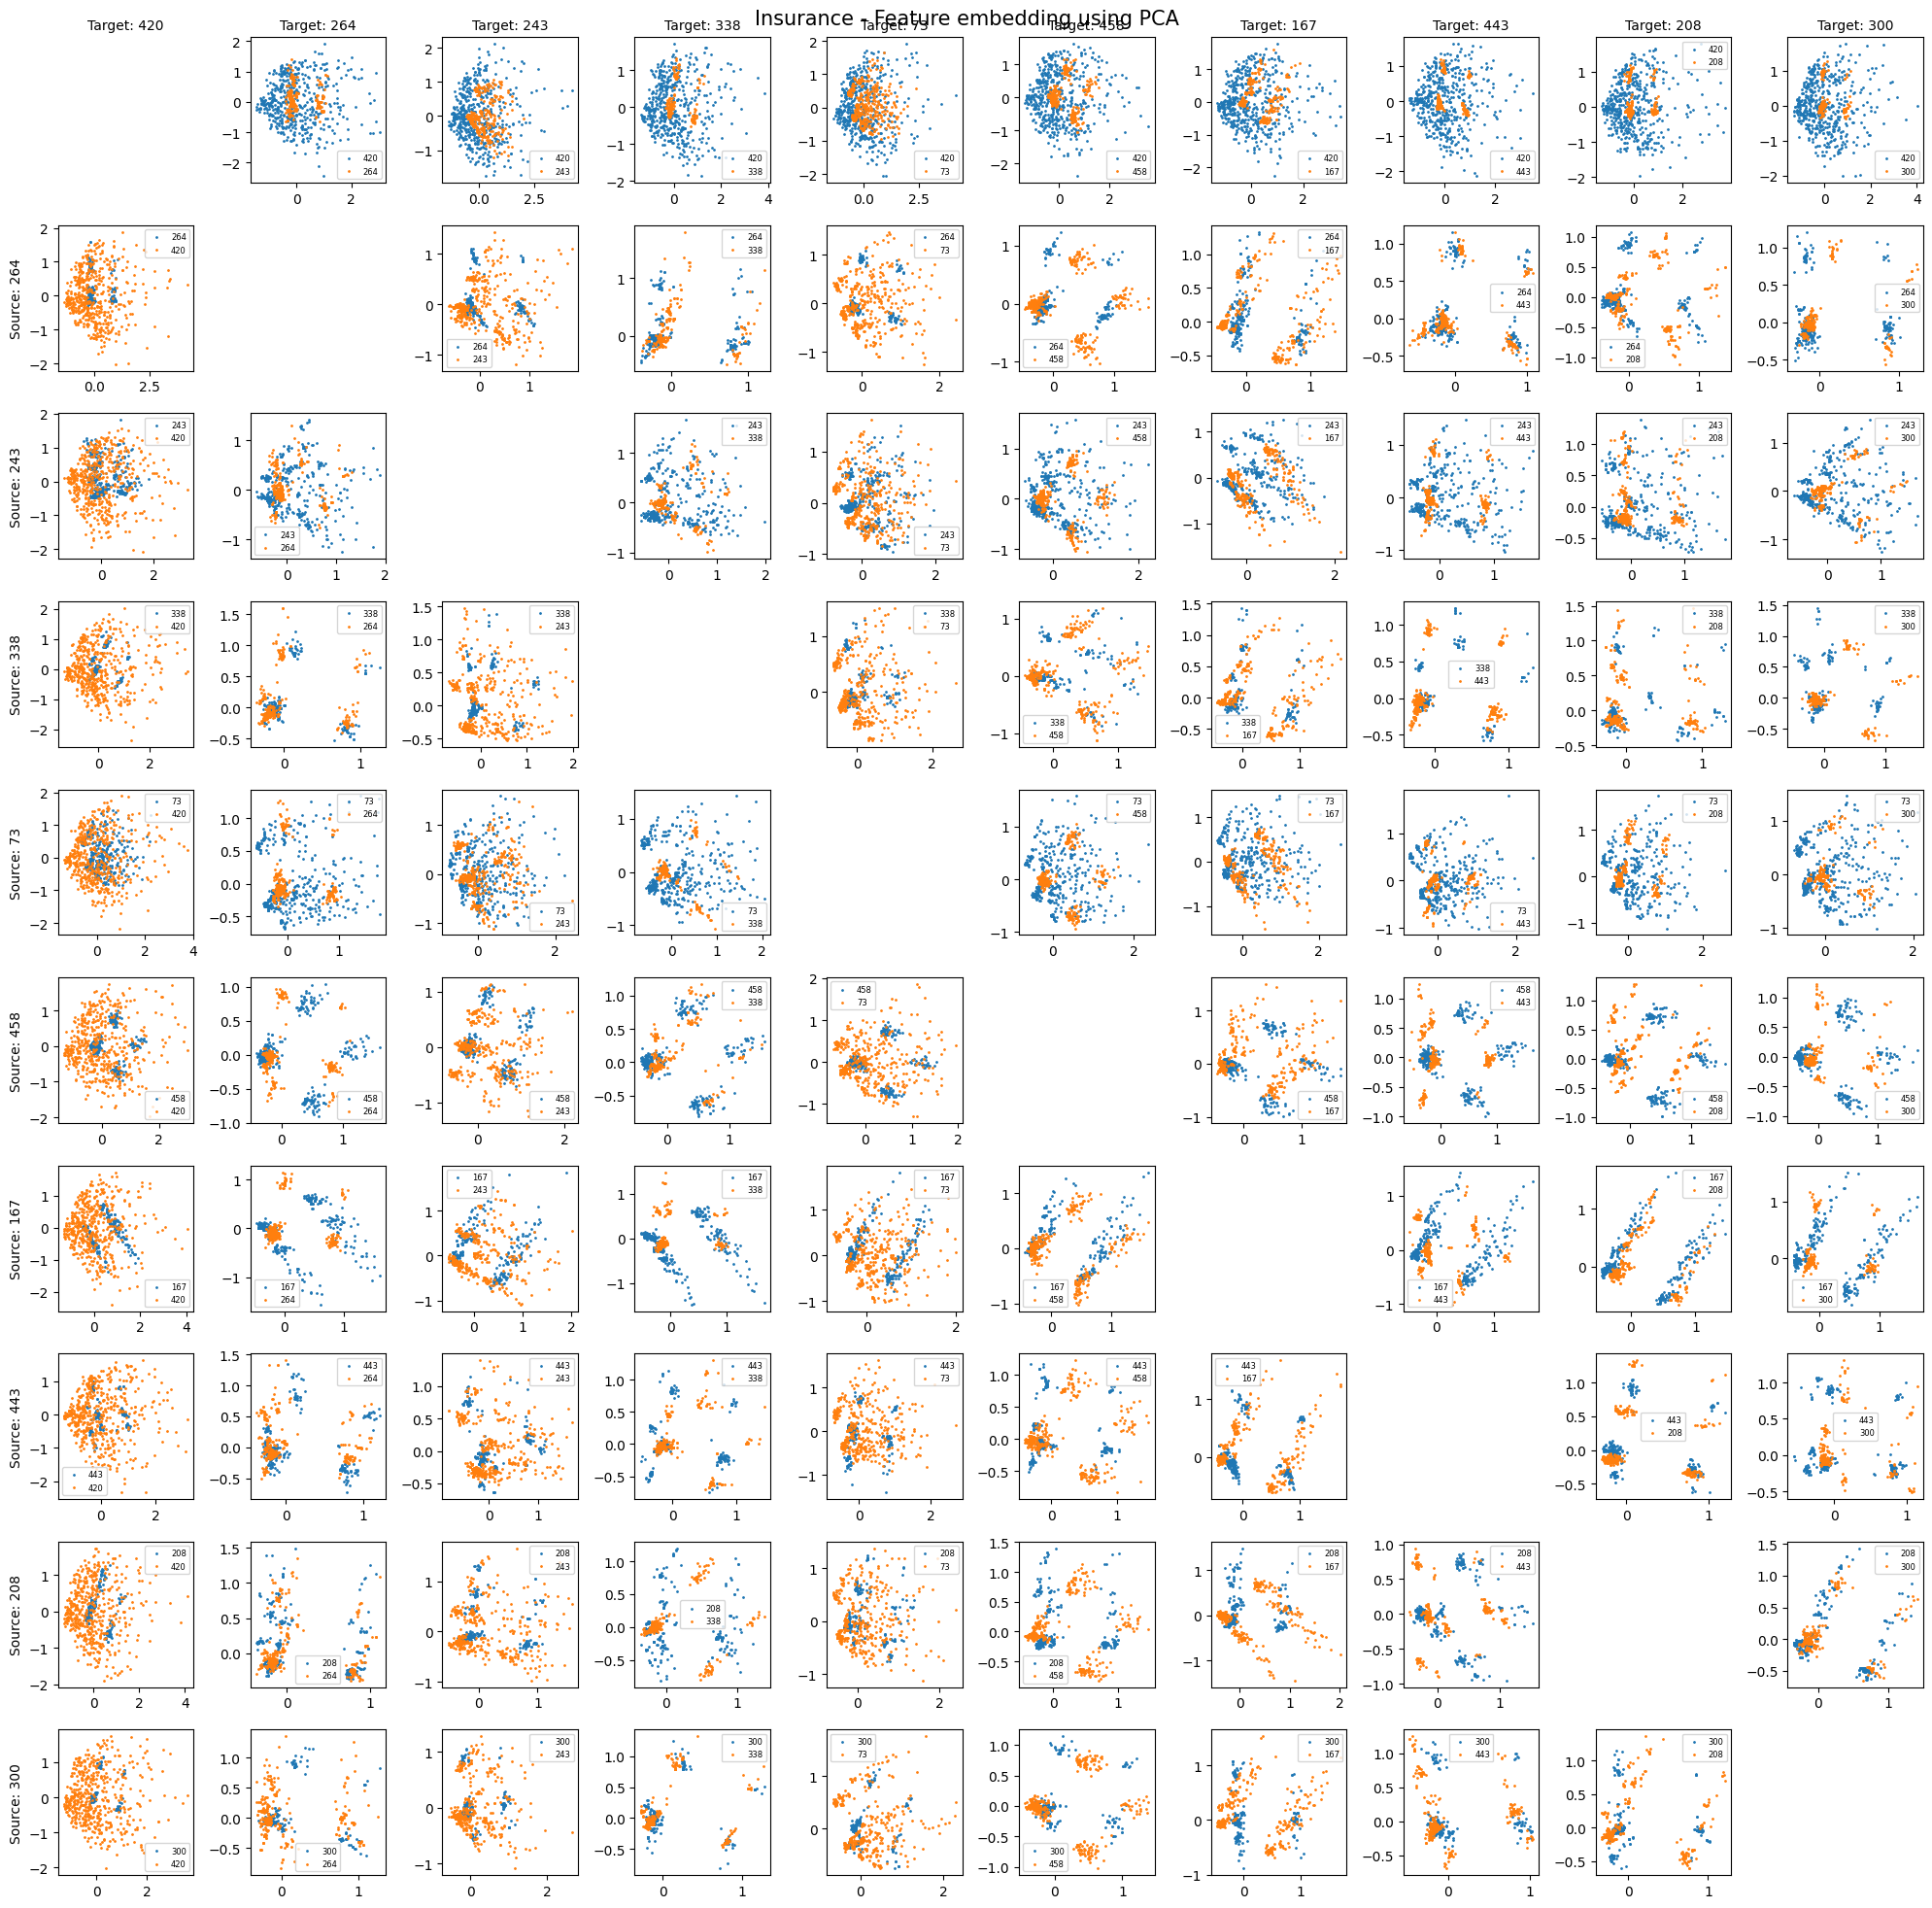

In [6]:
# Set parameters 
output_dir = eICU_output_dir
n_components = 50
source_count = 500
target_count = 500
type = 'cat'
input_name = 'ICD codes'
output_name = 'duration'
full_df = pd.read_csv(os.path.join(eICU_data_dir, "admission_patient_diagnosis_ICD.csv"), index_col=None, header=0, converters={'ICD codes': literal_eval})

group_name = 'hospitalid'
groups = [420, 264, 243, 338, 73, 458, 167, 443, 208, 300]

# Plot pairwise plots 
fig, axs = plt.subplots(len(groups), len(groups))
fig.set_figwidth(2*10)
fig.set_figheight(2*10)

for i, group_1 in enumerate(groups):
    for j, group_2 in enumerate(groups):
        if j == 0:
            axs[i, j].set_ylabel(f'Source: {group_1}', fontsize=10)
        if i == 0:
            axs[i, j].set_title(f'Target: {group_2}', fontsize=10)
        if group_1 == group_2:
            axs[i, j].axis('off')
            continue
        plot_pair(full_df, group_name, type, group_1, group_2, \
                  source_count, target_count, input_name, output_name, axs[i,j], n_components)

fig.suptitle(f"Insurance - Feature embedding using PCA", fontsize=15)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, f"{group_name}_distn_shift.pdf"))


Conduct Mann-Whitney U test to assess the distributional shifts between the embeddings in terms of medians


In [5]:
for i, source in enumerate(groups):
    for j, target in enumerate(groups):
        if i == j:
            continue 
        print("Source is:", source, "Target is:", target)
        selected_df = select_samples(full_df, group_name, type, source, target, source_count=source_count, target_count=target_count)

        source_features, _, target_features, _ = gen_code_feature_label(selected_df, group_name, type, source, target, input_name, output_name)

        source_reps, target_reps = custom_train_reps(source_features, target_features, n_components)

        # Results storage
        results_mann_whitney = []

        # Perform the tests for each dimension
        test_dim_num = 2 # only test the first two dimension
        for k in range(2):
            # Mann-Whitney U test for the i-th dimension
            u_stat, u_p_value = stats.mannwhitneyu(source_reps[:, k], target_reps[:, k], alternative='two-sided')
            results_mann_whitney.append((u_stat, u_p_value))
            

        # Output results
        for _, mw_res in enumerate (results_mann_whitney):
            print(f"  Mann-Whitney U test stats: {mw_res[0]}, p-value: {mw_res[1]:.2e}")
            if mw_res[1] < 0.05:
                print("  Significant difference in medians.")
            else:
                print("  No significant difference in medians.")
    


Source is: 420 Target is: 264


number of target indices is: 4375 target_count is: 500
number of source indices is: 4463 source_count is: 500
number of codes is: 475
  Mann-Whitney U test stats: 109414.0, p-value: 6.43e-04
  Significant difference in medians.
  Mann-Whitney U test stats: 113733.0, p-value: 1.36e-02
  Significant difference in medians.
Source is: 420 Target is: 243
number of target indices is: 3919 target_count is: 500
number of source indices is: 4463 source_count is: 500
number of codes is: 485
  Mann-Whitney U test stats: 116477.0, p-value: 6.20e-02
  No significant difference in medians.
  Mann-Whitney U test stats: 125247.0, p-value: 9.57e-01
  No significant difference in medians.
Source is: 420 Target is: 338
number of target indices is: 3538 target_count is: 500
number of source indices is: 4463 source_count is: 500
number of codes is: 483
  Mann-Whitney U test stats: 109608.0, p-value: 7.50e-04
  Significant difference in medians.
  Mann-Whitney U test stats: 126167.0, p-value: 7.98e-01
  No 